In [1]:
import numpy as np 
import networkx as nx 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt  
import scipy 
import pickle
from funcs import * 

In [2]:
G = nx.read_gpickle("data/BaseGraph03_NOR_wagrades.pickle")
labels = {n[1]:n[0] for n in enumerate(G.nodes)}

G = nx.relabel_nodes(G, labels)

pos = get_inverted_latlon(G)

# Connected k-Dominating Set

In [3]:
# Load data and parameters

sets = pickle.load(open("data/ConnDomSets.pickle", "rb"))
prunes = pickle.load(open("data/ConnDomPrunes.pickle", "rb"))


R = [20,30,40]
set_params = []
for r in R:
    k = [1,2,3,4]
    for i in k:
        set_params.append([r,i])
        # for s in range(5):
        #     set_params.append([r,i,s])

In [4]:
categories = [(n[0], n[1]) for n in set_params]

In [5]:
data = pd.DataFrame(columns=["range", "k", "n"])

In [6]:
count = 0
index = ["range", "k", "n"]
for i in categories:

    d = [i[0], i[1], len(sets[count])]
    # data['range'] = i[0] 
    # data['k'] = i[1]
    # data['setlen'] = len(sets[count])
    data = data.append(pd.Series(d, index = index), ignore_index=True)
    count += 1

## Calculate statistics for each category

In [7]:
# For each reachability graph, print number of edges and compute edges
R = [10, 15, 20,30,40]
degs = []
n_nodes = None
n_edges = []
for r in R:
    subdegs = []
    A = scipy.sparse.load_npz('data/Reachability_03_{}kwh_UNDIRECTED.npz'.format(r))
    n = A.count_nonzero()
    n_nodes = A.shape[0]
    print("Number of edges in {} kwh reachability graph:\t{}".format(r, n))
    n_edges.append(n)

    for i in range(A.shape[0]):
        deg = A[i,].count_nonzero()
        subdegs.append(deg)
    degs.append(subdegs)
    del(A)

Number of edges in 10 kwh reachability graph:	7758978
Number of edges in 15 kwh reachability graph:	12065776
Number of edges in 20 kwh reachability graph:	16927686
Number of edges in 30 kwh reachability graph:	28776480
Number of edges in 40 kwh reachability graph:	41709348


In [8]:
i = 0
for d in degs:
    print("=========================")
    print("Range {}".format(R[i]))
    print("Min:\t\t{}".format(np.min(d)))
    print("Mean:\t\t{}".format(round(np.mean(d),3)))
    print("Max:\t\t{}".format(np.max(d)))

    potential_connections = (n_nodes*(n_nodes - 1))/2
    density = n_edges[i]/potential_connections

    print("Density:\t{}".format(round(density, 3)))

    i += 1

Range 10
Min:		0
Mean:		426.716
Max:		1883
Density:	0.047
Range 15
Min:		0
Mean:		663.575
Max:		2358
Density:	0.073
Range 20
Min:		2
Mean:		930.962
Max:		3074
Density:	0.102
Range 30
Min:		3
Mean:		1582.604
Max:		4801
Density:	0.174
Range 40
Min:		4
Mean:		2293.865
Max:		6020
Density:	0.252


In [9]:
reducs = []
for p in prunes:
    reduc = (p[1] - p[0])/p[0]
    reducs.append(reduc)

print(np.mean(reducs))

-0.0689430525948329


In [10]:
reducs

[-0.013333333333333334,
 -0.05919661733615222,
 -0.08358208955223881,
 -0.08946772366930918,
 -0.01875,
 -0.06201550387596899,
 -0.0987012987012987,
 -0.10609037328094302,
 0.0,
 -0.07926829268292683,
 -0.11020408163265306,
 -0.10670731707317073]

In [11]:

# Instantiate sets of global data collectors
dists = []
neighbors = []
locs = []


# For each set in the collection, compute values:
counter = 0
for s in sets:

    to_iterate = [n[0] for n in enumerate(G.nodes) if n[0] not in s]

    if counter < 4:
        A = scipy.sparse.load_npz('data/Reachability_03_20kwh_UNDIRECTED.npz')
    if counter >= 4:
        A = scipy.sparse.load_npz('data/Reachability_03_30kwh_UNDIRECTED.npz')
    if counter >= 8:
        A = scipy.sparse.load_npz('data/Reachability_03_40kwh_UNDIRECTED.npz')

    # Statistics of sets:
    all_dists = []
    n_neighbors = []
    coords = []


    # For each row, compute:
    for i in to_iterate:
        a = A[i,list(s)]
        a_data = a.data

        # Store distance data
        for j in a_data:
            all_dists.append(j)

        # Store neighbor a_data
        n = len(a_data)
        n_neighbors.append(n)

        # Store coordinates
        x = G.nodes[i]
        y = G.nodes[i]
        coords.append((x,y))

    
    # Append to full collection
    dists.append(all_dists)
    neighbors.append(n_neighbors)
    counter += 1
    locs.append(coords)

In [12]:
data['category'] = list(zip(data.range, data.k))

In [13]:
data.head()

,range,k,n,category
0,20,1,296,"(20, 1)"
1,20,2,445,"(20, 2)"
2,20,3,614,"(20, 3)"
3,20,4,804,"(20, 4)"
4,30,1,157,"(30, 1)"


In [14]:
data2 = pd.DataFrame(data['category'].drop_duplicates())

In [15]:
[len(i) for i in sets]

[296, 445, 614, 804, 157, 242, 347, 455, 99, 151, 218, 293]

In [16]:
# Map distances to each category
data2['Mean dist.'] = [round(np.mean(i), 3) for i in dists]
data2['Median dist.'] = [round(np.median(i),3) for i in dists]
data2['Max dist.'] = [round(np.max(i),3) for i in dists]
data2['Min dist.'] = [round(np.min(i),4) for i in dists]
data2['$|D|_1$'] = [p[0] for p in prunes]
data2['$|D|_2$'] = [len(i) for i in sets]


# Map n neighbors to each category
data2['Mean nbrs.'] = [round(np.mean(i),3) for i in neighbors]
data2['Median nbrs.'] = [int(np.median(i)) for i in neighbors]
data2['St.dev.'] = [np.round(np.std(i),3) for i in neighbors]
data2['Max nbrs.'] = [np.max(i) for i in neighbors]
data2['Min nbrs.'] = [np.min(i) for i in neighbors]

In [17]:
distances = data2[['category', 'Mean dist.', 'Median dist.', 'Min dist.', '$|D|_1$', '$|D|_2$']]
nbrs = data2[['category', 'Mean nbrs.', 'Median nbrs.','St.dev.', 'Min nbrs.', 'Max nbrs.']]

In [18]:
# Print results of comparison
print(distances.to_latex(index = False))

\begin{tabular}{lrrrrr}
\toprule
category &  Mean dist. &  Median dist. &  Min dist. &  \$|D|\_1\$ &  \$|D|\_2\$ \\
\midrule
 (20, 1) &      11.691 &        12.447 &     0.0030 &      300 &      296 \\
 (20, 2) &      11.526 &        12.316 &     0.0022 &      473 &      445 \\
 (20, 3) &      11.538 &        12.242 &     0.0019 &      670 &      614 \\
 (20, 4) &      11.558 &        12.283 &     0.0016 &      883 &      804 \\
 (30, 1) &      18.270 &        19.737 &     0.0024 &      160 &      157 \\
 (30, 2) &      18.272 &        20.092 &     0.0024 &      258 &      242 \\
 (30, 3) &      18.427 &        20.228 &     0.0024 &      385 &      347 \\
 (30, 4) &      18.344 &        20.226 &     0.0022 &      509 &      455 \\
 (40, 1) &      24.563 &        26.106 &     0.0026 &       99 &       99 \\
 (40, 2) &      24.637 &        26.804 &     0.0024 &      164 &      151 \\
 (40, 3) &      25.067 &        27.430 &     0.0010 &      245 &      218 \\
 (40, 4) &      24.842 &    

In [19]:
# Print results of comparison
print(nbrs.to_latex(index = False))

\begin{tabular}{lrrrrr}
\toprule
category &  Mean nbrs. &  Median nbrs. &  St.dev. &  Min nbrs. &  Max nbrs. \\
\midrule
 (20, 1) &       2.949 &             3 &    0.978 &          1 &          6 \\
 (20, 2) &       4.364 &             4 &    1.324 &          2 &          9 \\
 (20, 3) &       6.055 &             6 &    1.900 &          3 &         13 \\
 (20, 4) &       8.163 &             8 &    2.618 &          4 &         17 \\
 (30, 1) &       3.079 &             3 &    1.058 &          1 &          6 \\
 (30, 2) &       4.564 &             4 &    1.520 &          2 &          9 \\
 (30, 3) &       6.766 &             6 &    2.186 &          3 &         15 \\
 (30, 4) &       8.766 &             9 &    2.696 &          4 &         18 \\
 (40, 1) &       3.353 &             3 &    1.208 &          1 &          7 \\
 (40, 2) &       4.469 &             4 &    1.639 &          2 &         11 \\
 (40, 3) &       6.400 &             6 &    2.314 &          3 &         15 \\
 (40, 4) &

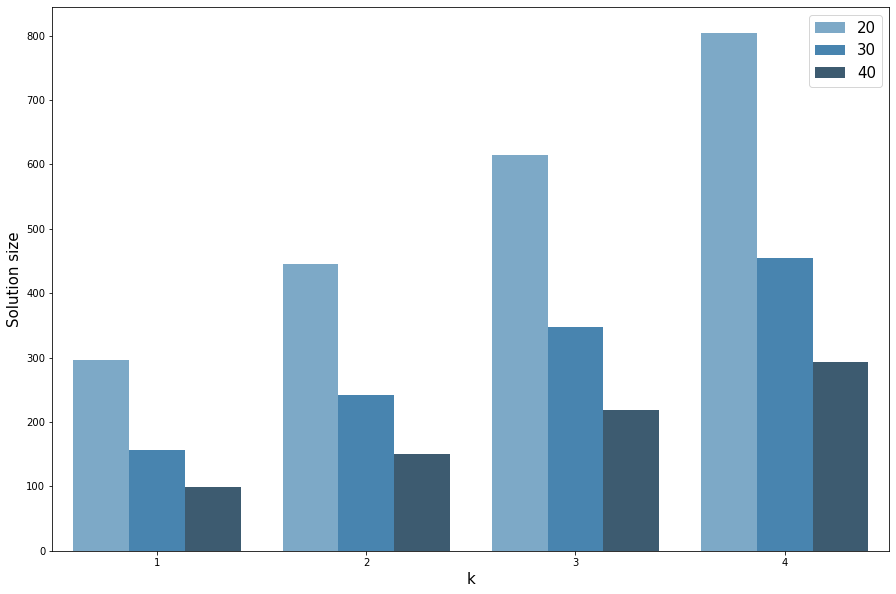

In [20]:
# Show how size of set changes when range changes, for k = 2
# For range
hue1 = ['20 kWh', '30 kWh', '40 kWh']
dat1 = [len(sets[1]), len(sets[5]), len(sets[9])]

plt.figure(figsize = (15,10))

# Solution size pr k
sns.barplot(x = data['k'], y = data['n'], hue = data['range'], palette = 'Blues_d')
plt.xlabel('k', fontsize = 15)
plt.ylabel('Solution size', fontsize = 15)
# plt.title('C-kDS solution size for each range and k', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.legend(fontsize = 15) 
plt.savefig('figures/ckds_sizedev.png', dpi = 400, bbox_inches = 'tight')

In [21]:
# Plot 30 and 40 kWh, k = 2, sets

D20 = sets[1]
D30 = sets[5]
D40 = sets[9]


color_map = []
size_map = []

for i in G.nodes:
    if i in D30:
        color_map.append('red')
        size_map.append(10)
    else:
        color_map.append('blue')
        size_map.append(0)

plt.figure(figsize = (10,10))
nx.draw(G, pos = pos, node_color = color_map, node_size = size_map)
plt.savefig('figures/D30_k2.png', dpi = 400, bbox_inches = 'tight')
plt.close()


color_map = []
size_map = []

for i in G.nodes:
    if i in D40:
        color_map.append('red')
        size_map.append(10)
    else:
        color_map.append('blue')
        size_map.append(0)

plt.figure(figsize = (10,10))
nx.draw(G, pos = pos, node_color = color_map, node_size = size_map)
plt.savefig('figures/D40_k2.png', dpi = 400, bbox_inches = 'tight')
plt.close()

In [22]:
len(D30)

242

# k-Dominating Set

In [23]:
# Load data
domsets = pickle.load(open("data/DomSets.pickle", "rb"))

In [24]:
R = [10,15,20]
set_params = []
for r in R:
    k = [1,2,3,4]
    for i in k:
        set_params.append([r,i])

In [25]:
categories = [(n[0], n[1]) for n in set_params]
data = pd.DataFrame(columns=["range", "k", "n"])


count = 0
index = ["range", "k", "n"]
for i in categories:

    d = [i[0], i[1], len(domsets[count])]
    # data['range'] = i[0] 
    # data['k'] = i[1]
    # data['setlen'] = len(sets[count])
    data = data.append(pd.Series(d, index = index), ignore_index=True)
    count += 1

In [26]:
# Instantiate sets of global data collectors
dists = []
neighbors = []
locs = []


# For each set in the mins collection, compute values:
counter = 0
for s in domsets:

    to_iterate = [n[0] for n in enumerate(G.nodes) if n[0] not in s]

    if counter < 4:
        A = scipy.sparse.load_npz('data/Reachability_03_10kwh_UNDIRECTED.npz')
    if counter >= 4:
        A = scipy.sparse.load_npz('data/Reachability_03_15kwh_UNDIRECTED.npz')
    if counter >= 8:
        A = scipy.sparse.load_npz('data/Reachability_03_20kwh_UNDIRECTED.npz')

    # Statistics of sets:
    all_dists = []
    n_neighbors = []
    coords = []


    # For each row, compute:
    for i in to_iterate:
        a = A[i,list(s)]
        a_data = a.data

        # Store distance data
        for j in a_data:
            all_dists.append(j)

        # Store neighbor a_data
        n = len(a_data)
        n_neighbors.append(n)

        # Store coordinates
        x = G.nodes[i]
        y = G.nodes[i]
        coords.append((x,y))

    
    # Append to full collection
    dists.append(all_dists)
    neighbors.append(n_neighbors)
    counter += 1
    locs.append(coords)

In [27]:
data['category'] = list(zip(data.range, data.k))

In [28]:
data2 = pd.DataFrame(data['category'].drop_duplicates())

In [29]:
# Map distances to each category
data2['Mean dist.'] = [round(np.mean(i), 3) for i in dists]
data2['Median dist.'] = [round(np.median(i),3) for i in dists]
data2['Max dist.'] = [round(np.max(i),3) for i in dists]
data2['Min dist.'] = [round(np.min(i),4) for i in dists]
# data2['$|D|_1$'] = [p[0] for p in prunes]
data2['$|D|$'] = [len(i) for i in domsets]


# Map n neighbors to each category
data2['Mean nbrs.'] = [round(np.mean(i),3) for i in neighbors]
data2['Median nbrs.'] = [int(np.median(i)) for i in neighbors]
data2['St.dev.'] = [np.round(np.std(i),3) for i in neighbors]
data2['Max nbrs.'] = [np.max(i) for i in neighbors]
data2['Min nbrs.'] = [np.min(i) for i in neighbors]

In [30]:
distances = data2[['category', 'Mean dist.', 'Median dist.', 'Min dist.', '$|D|$']]
nbrs = data2[['category', 'Mean nbrs.', 'Median nbrs.','St.dev.', 'Min nbrs.', 'Max nbrs.']]

In [31]:
# Print results of comparison
print(distances.to_latex(index = False))

\begin{tabular}{lrrrr}
\toprule
category &  Mean dist. &  Median dist. &  Min dist. &  \$|D|\$ \\
\midrule
 (10, 1) &       5.449 &         5.781 &     0.0014 &    531 \\
 (10, 2) &       5.323 &         5.588 &     0.0014 &    914 \\
 (10, 3) &       5.348 &         5.604 &     0.0009 &   1293 \\
 (10, 4) &       5.394 &         5.722 &     0.0009 &   1589 \\
 (15, 1) &       8.449 &         9.084 &     0.0015 &    340 \\
 (15, 2) &       8.179 &         8.637 &     0.0013 &    621 \\
 (15, 3) &       8.215 &         8.820 &     0.0013 &    861 \\
 (15, 4) &       8.127 &         8.574 &     0.0013 &   1084 \\
 (20, 1) &      10.922 &        11.476 &     0.0020 &    237 \\
 (20, 2) &      11.167 &        11.657 &     0.0016 &    443 \\
 (20, 3) &      11.213 &        11.904 &     0.0015 &    635 \\
 (20, 4) &      10.786 &        11.233 &     0.0011 &    807 \\
\bottomrule
\end{tabular}



In [32]:
# Combute neighbors for double range

# Instantiate sets of global data collectors
neighbors = []
locs = []


# For each set in the mins collection, compute values:
counter = 0
for s in domsets:

    to_iterate = [n[0] for n in enumerate(G.nodes) if n[0] not in s]

    if counter < 4:
        A = scipy.sparse.load_npz('data/Reachability_03_20kwh_UNDIRECTED.npz')
    if counter >= 4:
        A = scipy.sparse.load_npz('data/Reachability_03_30kwh_UNDIRECTED.npz')
    if counter >= 8:
        A = scipy.sparse.load_npz('data/Reachability_03_40kwh_UNDIRECTED.npz')

    # Statistics of sets:
    n_neighbors = []
    coords = []


    # For each row, compute:
    for i in to_iterate:
        a = A[i,list(s)]
        a_data = a.data

        # Store neighbor a_data
        n = len(a_data)
        n_neighbors.append(n)

        # Store coordinates
        x = G.nodes[i]
        y = G.nodes[i]
        coords.append((x,y))

    
    # Append to full collection
    neighbors.append(n_neighbors)
    counter += 1
    locs.append(coords)

data['category'] = list(zip(data.range, data.k))
data2 = pd.DataFrame(data['category'].drop_duplicates())

# Map n neighbors to each category
data2['Mean nbrs.'] = [round(np.mean(i),3) for i in neighbors]
data2['Median nbrs.'] = [int(np.median(i)) for i in neighbors]
data2['St.dev.'] = [np.round(np.std(i),3) for i in neighbors]
data2['Max nbrs.'] = [np.max(i) for i in neighbors]
data2['Min nbrs.'] = [np.min(i) for i in neighbors]

nbrs = data2[['category', 'Mean nbrs.', 'Median nbrs.','St.dev.', 'Min nbrs.', 'Max nbrs.']]

print(nbrs.to_latex(index = False))

\begin{tabular}{lrrrrr}
\toprule
category &  Mean nbrs. &  Median nbrs. &  St.dev. &  Min nbrs. &  Max nbrs. \\
\midrule
 (10, 1) &       5.870 &             6 &    2.246 &          1 &         12 \\
 (10, 2) &      10.358 &            10 &    3.565 &          2 &         20 \\
 (10, 3) &      14.996 &            14 &    4.974 &          3 &         30 \\
 (10, 4) &      19.783 &            19 &    6.512 &          4 &         36 \\
 (15, 1) &       6.977 &             6 &    2.656 &          1 &         14 \\
 (15, 2) &      12.472 &            12 &    3.587 &          2 &         21 \\
 (15, 3) &      18.455 &            18 &    5.723 &          3 &         33 \\
 (15, 4) &      23.819 &            23 &    7.333 &          4 &         41 \\
 (20, 1) &       6.992 &             7 &    2.359 &          1 &         12 \\
 (20, 2) &      13.262 &            13 &    3.366 &          2 &         21 \\
 (20, 3) &      19.332 &            19 &    5.250 &          3 &         34 \\
 (20, 4) &

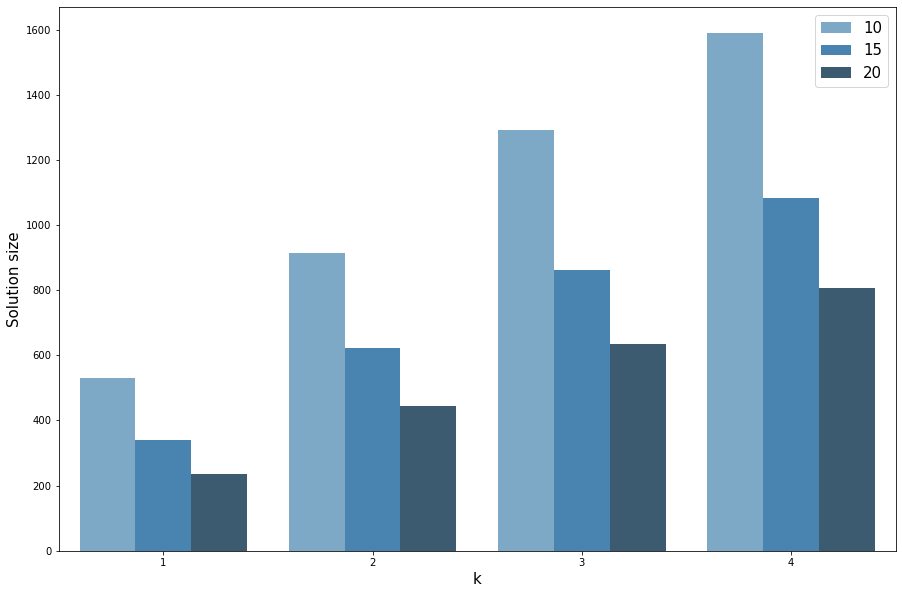

In [33]:
# Show how size of set changes when range changes, for k = 2

plt.figure(figsize = (15,10))


# Solution size pr k
sns.barplot(x = data['k'], y = data['n'], hue = data['range'], palette = 'Blues_d')
plt.xlabel('k', fontsize = 15)
plt.ylabel('Solution size', fontsize = 15)
# plt.title('C-kDS solution size for each range and k', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.legend(fontsize = 15) 
plt.savefig('figures/kds_sizedev.png', dpi = 400, bbox_inches = 'tight')